## Project 3: Trading Bot

### Prompt

*"You've just determined a winning stock market trading strategy. The problem? It requires you to make trades extremely precisely -- with little room for error. Build your own algorithmic trading bot -- capable of responding to incoming market data in real-time."*

### Approach

I'm going to recreate [this notebook](https://github.com/ORE93/Automated-Algorithmic-Trading-Bot/blob/main/Algo_trade.ipynb) and then see if I can improve on their results. Their solution relies on the [Alpaca trade API](https://docs.alpaca.markets/docs/getting-started-with-trading-api), which in turn relies on Python 3.10, so I switched to a new virtual environment using [Miniconda](https://docs.conda.io/en/latest/miniconda.html) and [these packages](./requirements-310.txt).

In [1]:
import pandas
import numpy
import json
import time
import seaborn
import matplotlib.pyplot as matplot
from matplotlib.dates import DayLocator
from alpaca.data.historical import StockHistoricalDataClient #, CryptoHistoricalDataClient
from alpaca.data.requests import StockBarsRequest #, CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from datetime import datetime, timedelta
from finta import TA
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier

In [2]:
with open('./api/alpaca-paper.json') as keyfile: api = json.load(keyfile)
stock_client = StockHistoricalDataClient(api['KEY'], api['SECRET'])

In [3]:
data_req = StockBarsRequest(symbol_or_symbols='X', timeframe=TimeFrame.Day, start=datetime(2023, 1, 1), end=datetime(2023, 3, 31))
hist_data = stock_client.get_stock_bars(data_req).df
hist_data

open     high    low  close     volume  \
symbol timestamp                                                            
X      2023-01-03 05:00:00+00:00  25.30  25.7700  24.84  25.04  5294483.0   
       2023-01-04 05:00:00+00:00  24.77  25.5000  24.33  25.23  6494526.0   
       2023-01-05 05:00:00+00:00  25.11  25.6900  24.57  25.45  5754605.0   
       2023-01-06 05:00:00+00:00  25.84  26.9399  25.77  26.90  7629539.0   
       2023-01-09 05:00:00+00:00  27.33  27.3900  26.45  26.47  5452554.0   
...                                 ...      ...    ...    ...        ...   
       2023-03-24 04:00:00+00:00  24.51  25.1000  23.95  25.00  8125204.0   
       2023-03-27 04:00:00+00:00  25.57  25.7904  24.85  25.50  7235131.0   
       2023-03-28 04:00:00+00:00  25.59  25.9600  25.49  25.76  4148095.0   
       2023-03-29 04:00:00+00:00  26.19  26.3100  25.86  26.11  5252120.0   
       2023-03-30 04:00:00+00:00  26.48  26.5350  25.89  26.12  4872941.0   

                                  trade_count       vwap  
symbol timestamp                                          
X      2023-01-03 05:00:00+00:00      43244.0  25.229963  
       2023-01-04 05:00:00+00:00      49848.0  25.089582  
       2023-01-05 05:00:00+00:00      42565.0  25.257925  
       2023-01-06 05:00:00+00:00      61557.0  26.550555  
       2023-01-09 05:00:00+00:00      45708.0  26.867340  
...                                       ...        ...  
       2023-03-24 04:00:00+00:00      54994.0  24.724356  
       2023-03-27 04:00:00+00:00      45708.0  25.376195  
       2023-03-28 04:00:00+00:00      31713.0  25.769452  
       2023-03-29 04:00:00+00:00      39920.0  26.065196  
       2023-03-30 04:00:00+00:00      32710.0  26.127723  

[61 rows x 7 columns]

### Wranglin' Time

Looks like they're using close and VWAP to calculate their other indicators/signals.

In [4]:
signals = hist_data.loc[:, ['close', 'vwap']] # vwap (volume-weighted average price) -> https://www.investopedia.com/terms/v/vwap.asp
signals['rsi'] = TA.RSI(hist_data) # rsi (relative strength index) -> https://www.investopedia.com/terms/r/rsi.asp
signals

close       vwap         rsi
symbol timestamp                                              
X      2023-01-03 05:00:00+00:00  25.04  25.229963         NaN
       2023-01-04 05:00:00+00:00  25.23  25.089582  100.000000
       2023-01-05 05:00:00+00:00  25.45  25.257925  100.000000
       2023-01-06 05:00:00+00:00  26.90  26.550555  100.000000
       2023-01-09 05:00:00+00:00  26.47  26.867340   79.700196
...                                 ...        ...         ...
       2023-03-24 04:00:00+00:00  25.00  24.724356   38.159985
       2023-03-27 04:00:00+00:00  25.50  25.376195   41.619519
       2023-03-28 04:00:00+00:00  25.76  25.769452   43.392919
       2023-03-29 04:00:00+00:00  26.11  26.065196   45.780584
       2023-03-30 04:00:00+00:00  26.12  26.127723   45.850861

[61 rows x 3 columns]

In [5]:
fast, slow = 4, 10
signals['sma_fast'] = signals['close'].rolling(fast).mean()
signals['sma_slow'] = signals['close'].rolling(slow).mean()
signals['sma_signal'] = 0.0
signals

close       vwap         rsi  sma_fast  \
symbol timestamp                                                           
X      2023-01-03 05:00:00+00:00  25.04  25.229963         NaN       NaN   
       2023-01-04 05:00:00+00:00  25.23  25.089582  100.000000       NaN   
       2023-01-05 05:00:00+00:00  25.45  25.257925  100.000000       NaN   
       2023-01-06 05:00:00+00:00  26.90  26.550555  100.000000   25.6550   
       2023-01-09 05:00:00+00:00  26.47  26.867340   79.700196   26.0125   
...                                 ...        ...         ...       ...   
       2023-03-24 04:00:00+00:00  25.00  24.724356   38.159985   25.2650   
       2023-03-27 04:00:00+00:00  25.50  25.376195   41.619519   25.1750   
       2023-03-28 04:00:00+00:00  25.76  25.769452   43.392919   25.3150   
       2023-03-29 04:00:00+00:00  26.11  26.065196   45.780584   25.5925   
       2023-03-30 04:00:00+00:00  26.12  26.127723   45.850861   25.8725   

                                  sma_slow  sma_signal  
symbol timestamp                                        
X      2023-01-03 05:00:00+00:00       NaN         0.0  
       2023-01-04 05:00:00+00:00       NaN         0.0  
       2023-01-05 05:00:00+00:00       NaN         0.0  
       2023-01-06 05:00:00+00:00       NaN         0.0  
       2023-01-09 05:00:00+00:00       NaN         0.0  
...                                    ...         ...  
       2023-03-24 04:00:00+00:00    25.275         0.0  
       2023-03-27 04:00:00+00:00    25.145         0.0  
       2023-03-28 04:00:00+00:00    25.016         0.0  
       2023-03-29 04:00:00+00:00    25.183         0.0  
       2023-03-30 04:00:00+00:00    25.343         0.0  

[61 rows x 6 columns]

Their strategy is to generate a 1 or 0 for a trade signal based on these rules:
- `sma_fast` > `sma_slow` AND `rsi` > 50 = 1
- `sma_fast` < `sma_slow` AND `rsi` < 50 = 0

The RSI and SMA signals are generated separately, then multiplied to implement the AND logic, and finally compared to the prior day to mark entries/exits (1/-1).

In [6]:
signals['sma_signal'][fast:] = numpy.where(signals['sma_fast'][fast:] > signals['sma_slow'][fast:], 1.0, 0.0)
signals['rsi_signal'] = numpy.where(signals['rsi'] > 50, 1.0, 0.0)
signals['stock_held'] = signals['sma_signal'][fast:] * signals['rsi_signal']
signals['entry_exit'] = signals['stock_held'].diff() # 1 = entry, -1 = exit, 0 = HODL
signals.fillna(0, inplace=True)
signals

close       vwap         rsi  sma_fast  \
symbol timestamp                                                           
X      2023-01-03 05:00:00+00:00  25.04  25.229963    0.000000    0.0000   
       2023-01-04 05:00:00+00:00  25.23  25.089582  100.000000    0.0000   
       2023-01-05 05:00:00+00:00  25.45  25.257925  100.000000    0.0000   
       2023-01-06 05:00:00+00:00  26.90  26.550555  100.000000   25.6550   
       2023-01-09 05:00:00+00:00  26.47  26.867340   79.700196   26.0125   
...                                 ...        ...         ...       ...   
       2023-03-24 04:00:00+00:00  25.00  24.724356   38.159985   25.2650   
       2023-03-27 04:00:00+00:00  25.50  25.376195   41.619519   25.1750   
       2023-03-28 04:00:00+00:00  25.76  25.769452   43.392919   25.3150   
       2023-03-29 04:00:00+00:00  26.11  26.065196   45.780584   25.5925   
       2023-03-30 04:00:00+00:00  26.12  26.127723   45.850861   25.8725   

                                  sma_slow  sma_signal  rsi_signal  \
symbol timestamp                                                     
X      2023-01-03 05:00:00+00:00     0.000         0.0         0.0   
       2023-01-04 05:00:00+00:00     0.000         0.0         1.0   
       2023-01-05 05:00:00+00:00     0.000         0.0         1.0   
       2023-01-06 05:00:00+00:00     0.000         0.0         1.0   
       2023-01-09 05:00:00+00:00     0.000         0.0         1.0   
...                                    ...         ...         ...   
       2023-03-24 04:00:00+00:00    25.275         0.0         0.0   
       2023-03-27 04:00:00+00:00    25.145         1.0         0.0   
       2023-03-28 04:00:00+00:00    25.016         1.0         0.0   
       2023-03-29 04:00:00+00:00    25.183         1.0         0.0   
       2023-03-30 04:00:00+00:00    25.343         1.0         0.0   

                                  stock_held  entry_exit  
symbol timestamp                                          
X      2023-01-03 05:00:00+00:00         0.0         0.0  
       2023-01-04 05:00:00+00:00         0.0         0.0  
       2023-01-05 05:00:00+00:00         0.0         0.0  
       2023-01-06 05:00:00+00:00         0.0         0.0  
       2023-01-09 05:00:00+00:00         0.0         0.0  
...                                      ...         ...  
       2023-03-24 04:00:00+00:00         0.0         0.0  
       2023-03-27 04:00:00+00:00         0.0         0.0  
       2023-03-28 04:00:00+00:00         0.0         0.0  
       2023-03-29 04:00:00+00:00         0.0         0.0  
       2023-03-30 04:00:00+00:00         0.0         0.0  

[61 rows x 9 columns]

In [7]:
signals = signals.reset_index(level=['symbol']).drop('symbol', axis=1) # remove multi-index
signals.head(30)

,close,vwap,rsi,sma_fast,sma_slow,sma_signal,rsi_signal,stock_held,entry_exit
timestamp,,,,,,,,,
2023-01-03 05:00:00+00:00,25.04,25.229963,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0
2023-01-04 05:00:00+00:00,25.23,25.089582,100.000000,0.0000,0.000,0.0,1.0,0.0,0.0
2023-01-05 05:00:00+00:00,25.45,25.257925,100.000000,0.0000,0.000,0.0,1.0,0.0,0.0
2023-01-06 05:00:00+00:00,26.90,26.550555,100.000000,25.6550,0.000,0.0,1.0,0.0,0.0
2023-01-09 05:00:00+00:00,26.47,26.867340,79.700196,26.0125,0.000,0.0,1.0,0.0,0.0
2023-01-10 05:00:00+00:00,27.69,27.215455,87.471203,26.6275,0.000,0.0,1.0,0.0,0.0
2023-01-11 05:00:00+00:00,27.56,27.516447,83.790357,27.1550,0.000,0.0,1.0,0.0,0.0
2023-01-12 05:00:00+00:00,28.77,28.221792,88.599231,27.6225,0.000,0.0,1.0,0.0,0.0
2023-01-13 05:00:00+00:00,28.35,28.385146,79.754699,28.0925,0.000,0.0,1.0,0.0,0.0


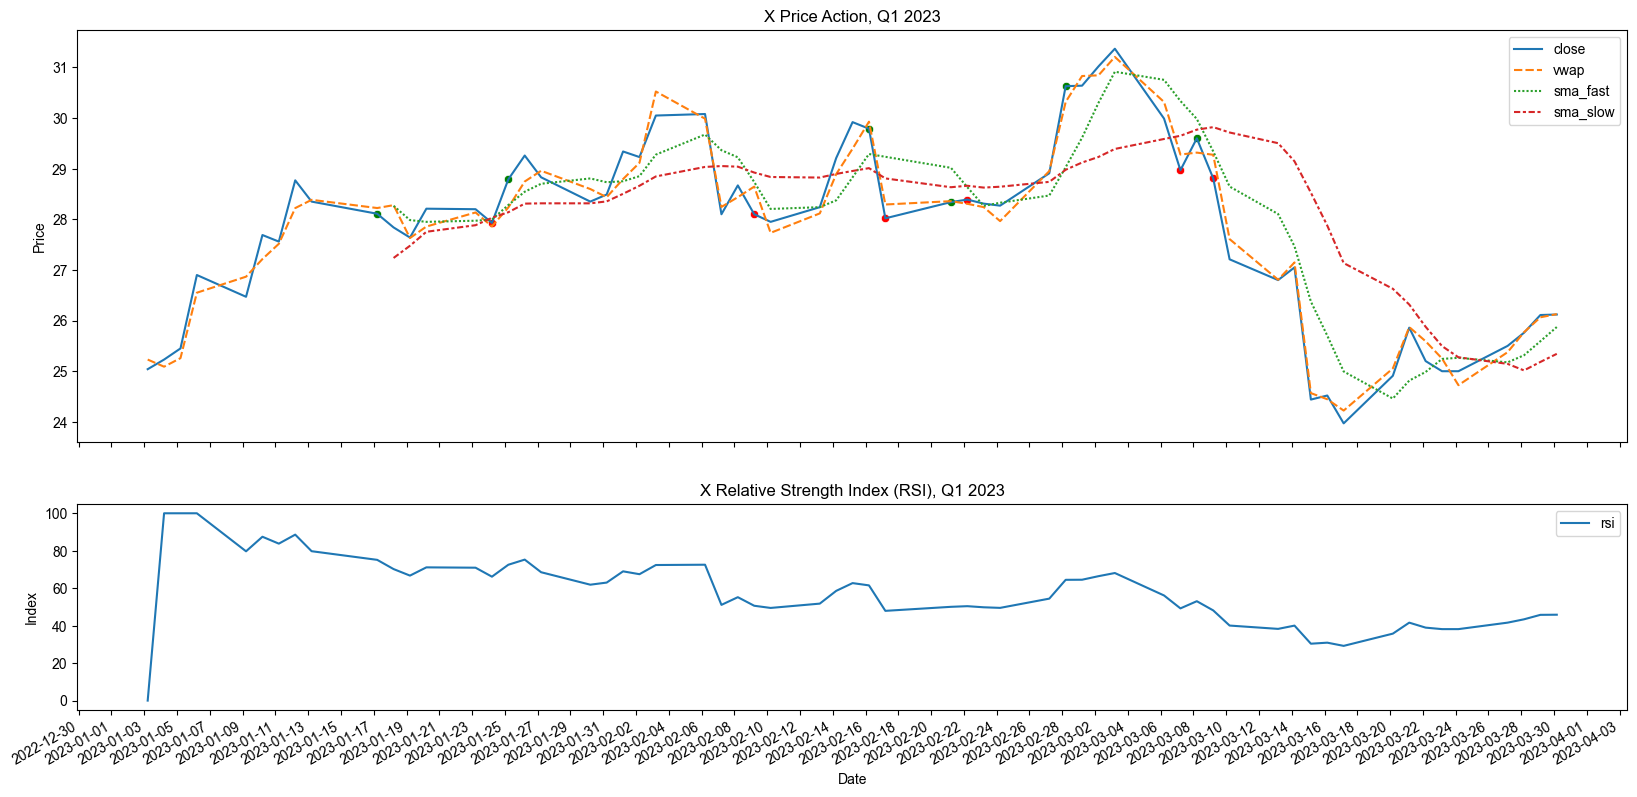

In [8]:
fig, axs = matplot.subplots(2, 1, figsize=(20, 10), height_ratios=[2, 1])

# close, vwap, and SMAs are joined so they can be displayed with different line styles easily. early SMAs are always 0 and thus dropped to hide them on the chart
seaborn.lineplot(data=pandas.concat([signals[['close', 'vwap']], signals[['sma_fast', 'sma_slow']][slow:]], axis=1), ax=axs[0])
seaborn.scatterplot(data=signals[signals['entry_exit'] == -1.0], x='timestamp', y='close', color='r', ax=axs[0])
seaborn.scatterplot(data=signals[signals['entry_exit'] == 1.0], x='timestamp', y='close', color='g', ax=axs[0])
axs[0].set_title('X Price Action, Q1 2023')
axs[0].set_ylabel('Price')
axs[0].set_xlabel('Date')
axs[0].xaxis.set_major_locator(DayLocator(interval=2))

# RSI gets its own chart since it's not scaled to price. the first day is always 0 but as this is the only plot, dropping day 1 would offset the dates displayed
seaborn.lineplot(data=signals[['rsi']], ax=axs[1])
axs[1].set_title('X Relative Strength Index (RSI), Q1 2023')
axs[1].set_ylabel('Index')
axs[1].set_xlabel('Date')
axs[1].xaxis.set_major_locator(DayLocator(interval=2))

# make dates easier to see 
fig.autofmt_xdate()
seaborn.set_style('whitegrid')

### Backtesting

In [9]:
# setup position data, starting captial, and starting shares
position_data = signals.loc[:, ['close', 'stock_held']]  #.drop(['vwap', 'sma_signal', 'rsi_signal'], axis=1)
capital_start = 100000.00
shares_traded = 90 # per entry/exit

# buy when signal == 1, sell when signal == 0
position_data['shares_owned'] = pandas.Series(shares_traded * position_data['stock_held'])
position_data['shares_traded'] = position_data['shares_owned'].diff() # makes a NaN on row 1 but that doesn't matter for this
position_data['stock_value'] = position_data['close'] * position_data['shares_owned']
position_data['cash_value'] = capital_start - (position_data['close'] * position_data['shares_traded']).cumsum() # unfortunate
position_data['total_value'] = position_data['cash_value'] + position_data['stock_value']
position_data['daily_return'] = position_data['total_value'].pct_change()
position_data['total_return'] = (1 + position_data['daily_return']).cumprod() - 1 # tragic

# position_data.head(30)
position_data.tail(20)

,close,stock_held,shares_owned,shares_traded,stock_value,cash_value,total_value,daily_return,total_return
timestamp,,,,,,,,,
2023-03-03 05:00:00+00:00,31.37,1.0,90.0,0.0,2823.3,97010.2,99833.5,0.000316,-0.001665
2023-03-06 05:00:00+00:00,29.99,1.0,90.0,0.0,2699.1,97010.2,99709.3,-0.001244,-0.002907
2023-03-07 05:00:00+00:00,28.97,0.0,0.0,-90.0,0.0,99617.5,99617.5,-0.000921,-0.003825
2023-03-08 05:00:00+00:00,29.60,1.0,90.0,90.0,2664.0,96953.5,99617.5,0.000000,-0.003825
2023-03-09 05:00:00+00:00,28.81,0.0,0.0,-90.0,0.0,99546.4,99546.4,-0.000714,-0.004536
2023-03-10 05:00:00+00:00,27.21,0.0,0.0,0.0,0.0,99546.4,99546.4,0.000000,-0.004536
2023-03-13 04:00:00+00:00,26.80,0.0,0.0,0.0,0.0,99546.4,99546.4,0.000000,-0.004536
2023-03-14 04:00:00+00:00,27.05,0.0,0.0,0.0,0.0,99546.4,99546.4,0.000000,-0.004536
2023-03-15 04:00:00+00:00,24.44,0.0,0.0,0.0,0.0,99546.4,99546.4,0.000000,-0.004536


Lost money like always. Time for the good stuff.

### Machine Learning

In [10]:
X = signals[['rsi', 'sma_fast', 'sma_slow']].shift().dropna() # shifted up by 1 b/c we don't know RSI, SMA's until the next trading day
X.head()

,rsi,sma_fast,sma_slow
timestamp,,,
2023-01-04 05:00:00+00:00,0.000000,0.0000,0.0
2023-01-05 05:00:00+00:00,100.000000,0.0000,0.0
2023-01-06 05:00:00+00:00,100.000000,0.0000,0.0
2023-01-09 05:00:00+00:00,100.000000,25.6550,0.0
2023-01-10 05:00:00+00:00,79.700196,26.0125,0.0


In [11]:
y = signals['stock_held']
y.value_counts()

0.0    37
1.0    24
Name: stock_held, dtype: int64

In [12]:
train_start = X.index.min()
train_start

Timestamp('2023-01-04 05:00:00+0000', tz='UTC')

In [13]:
train_end = train_start + DateOffset(months=2) # we'll do a 2:1 train:test split, I guess
train_end

Timestamp('2023-03-04 05:00:00+0000', tz='UTC')

In [14]:
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]

X_train.head()

,rsi,sma_fast,sma_slow
timestamp,,,
2023-01-04 05:00:00+00:00,0.000000,0.0000,0.0
2023-01-05 05:00:00+00:00,100.000000,0.0000,0.0
2023-01-06 05:00:00+00:00,100.000000,0.0000,0.0
2023-01-09 05:00:00+00:00,100.000000,25.6550,0.0
2023-01-10 05:00:00+00:00,79.700196,26.0125,0.0


In [15]:
y_train.head()

timestamp
2023-01-04 05:00:00+00:00    0.0
2023-01-05 05:00:00+00:00    0.0
2023-01-06 05:00:00+00:00    0.0
2023-01-09 05:00:00+00:00    0.0
2023-01-10 05:00:00+00:00    0.0
Name: stock_held, dtype: float64

In [16]:
X_train.tail()

,rsi,sma_fast,sma_slow
timestamp,,,
2023-02-27 05:00:00+00:00,49.502522,28.3275,28.644
2023-02-28 05:00:00+00:00,54.435351,28.4700,28.740
2023-03-01 05:00:00+00:00,64.478157,29.0300,28.979
2023-03-02 05:00:00+00:00,64.527110,29.6125,29.122
2023-03-03 05:00:00+00:00,66.420858,30.3000,29.232


In [17]:
y_train.tail()

timestamp
2023-02-27 05:00:00+00:00    0.0
2023-02-28 05:00:00+00:00    1.0
2023-03-01 05:00:00+00:00    1.0
2023-03-02 05:00:00+00:00    1.0
2023-03-03 05:00:00+00:00    1.0
Name: stock_held, dtype: float64

In [18]:
X_test = X.loc[train_end:]
y_test = y.loc[train_end:]

X_test.head()

,rsi,sma_fast,sma_slow
timestamp,,,
2023-03-06 05:00:00+00:00,68.109568,30.9150,29.390
2023-03-07 05:00:00+00:00,56.124653,30.7550,29.587
2023-03-08 05:00:00+00:00,49.229303,30.3375,29.650
2023-03-09 05:00:00+00:00,53.064839,29.9825,29.771
2023-03-10 05:00:00+00:00,48.152350,29.3425,29.821


In [19]:
y_test.head()

timestamp
2023-03-06 05:00:00+00:00    1.0
2023-03-07 05:00:00+00:00    0.0
2023-03-08 05:00:00+00:00    1.0
2023-03-09 05:00:00+00:00    0.0
2023-03-10 05:00:00+00:00    0.0
Name: stock_held, dtype: float64

In [20]:
scaler = StandardScaler() # scale values to standard deviations from the mean
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# setup SVM (support vector machine) to make predictions -> https://scikit-learn.org/stable/modules/svm.html
model = svm.SVC() # support vector classifier
model = model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
predictions[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
testing_report = classification_report(y_test, predictions)
print('SVM classifier report')
print(testing_report) # must call print() to display correctly

SVM classifier report
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        17
         1.0       1.00      0.50      0.67         2

    accuracy                           0.95        19
   macro avg       0.97      0.75      0.82        19
weighted avg       0.95      0.95      0.94        19



In [22]:
prediction_data = pandas.DataFrame(index=X_test.index)
prediction_data['predicted'] = predictions
prediction_data['strategy_returns'] = position_data['daily_return']
prediction_data['svm_algo_returns'] = position_data['daily_return'] * prediction_data['predicted']
prediction_data.tail(20)

,predicted,strategy_returns,svm_algo_returns
timestamp,,,
2023-03-06 05:00:00+00:00,1.0,-0.001244,-0.001244
2023-03-07 05:00:00+00:00,0.0,-0.000921,-0.000000
2023-03-08 05:00:00+00:00,0.0,0.000000,0.000000
2023-03-09 05:00:00+00:00,0.0,-0.000714,-0.000000
2023-03-10 05:00:00+00:00,0.0,0.000000,0.000000
2023-03-13 04:00:00+00:00,0.0,0.000000,0.000000
2023-03-14 04:00:00+00:00,0.0,0.000000,0.000000
2023-03-15 04:00:00+00:00,0.0,0.000000,0.000000
2023-03-16 04:00:00+00:00,0.0,0.000000,0.000000


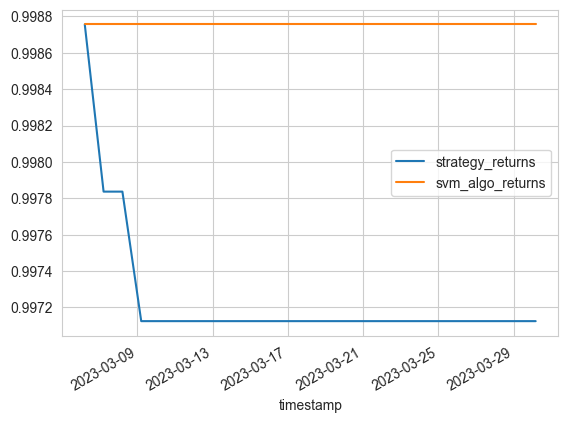

In [23]:
(1 + prediction_data[['strategy_returns', 'svm_algo_returns']]).cumprod().plot()
pass # the tabasco

I suspect I'll need more data to make this work.

### Groundhog Day

In [24]:
# params
start = datetime(2015, 12, 1) # as far back as Alpaca goes, apparently
end = datetime.today() # default to today
fast, slow = 4, 10

# preprocess
bars = stock_client.get_stock_bars(StockBarsRequest(symbol_or_symbols='X', timeframe=TimeFrame.Day, start=start, end=end)).df
data = bars.loc[:, ['close', 'vwap']]
data['rsi'] = TA.RSI(bars)
data['sma_fast'] = data['close'].rolling(fast).mean()
data['sma_slow'] = data['close'].rolling(slow).mean()
data['sma_signal'] = numpy.where(data['sma_fast'] > data['sma_slow'], 1, 0)
data['rsi_signal'] = numpy.where(data['rsi'] > 50, 1, 0)
data['stock_held'] = data['sma_signal'] * data['rsi_signal']
data['trade_flag'] = data['stock_held'].diff()
data = data.fillna(0).reset_index(level=['symbol']).drop('symbol', axis=1)
data

,close,vwap,rsi,sma_fast,sma_slow,sma_signal,rsi_signal,stock_held,trade_flag
timestamp,,,,,,,,,
2015-12-01 05:00:00+00:00,8.09,8.153738,0.000000,0.0000,0.000,0,0,0,0.0
2015-12-02 05:00:00+00:00,7.74,7.813687,0.000000,0.0000,0.000,0,0,0,0.0
2015-12-03 05:00:00+00:00,7.78,7.824743,10.958904,0.0000,0.000,0,0,0,0.0
2015-12-04 05:00:00+00:00,7.77,7.774118,10.644831,7.8450,0.000,0,0,0,0.0
2015-12-07 05:00:00+00:00,7.09,7.192965,3.435221,7.5950,0.000,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
2023-06-28 04:00:00+00:00,24.45,24.279901,63.958588,24.0925,23.748,1,1,1,0.0
2023-06-29 04:00:00+00:00,24.99,24.876080,67.660587,24.5075,23.891,1,1,1,0.0
2023-06-30 04:00:00+00:00,25.01,24.943356,67.792537,24.7875,24.006,1,1,1,0.0


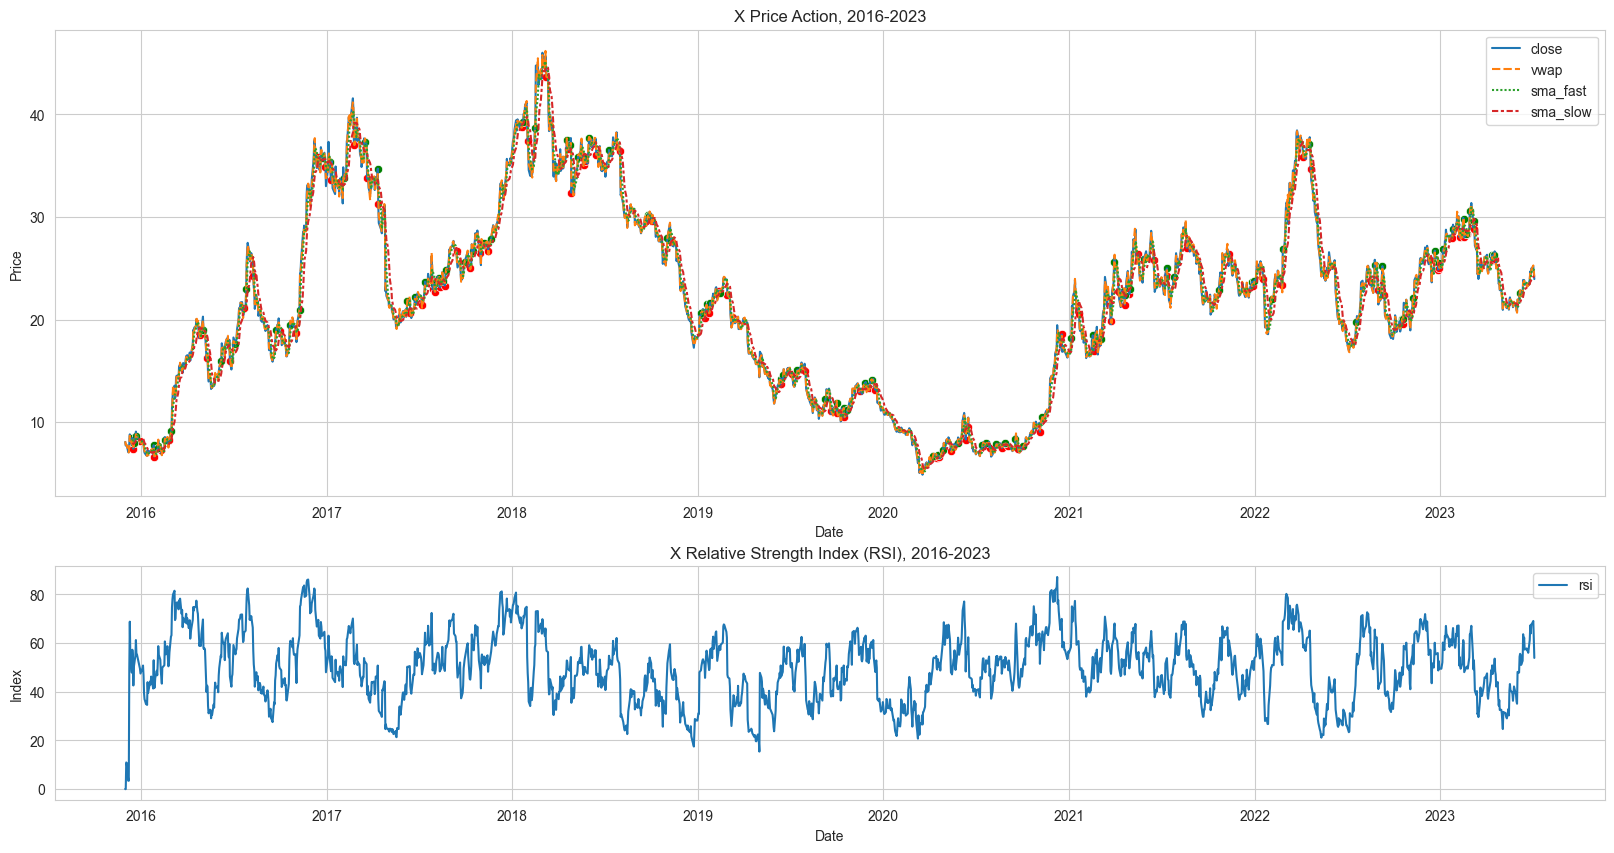

In [25]:
# display - do not use DateLocator on a timespan this large
fig, axs = matplot.subplots(2, 1, figsize=(20, 10), height_ratios=[2, 1])
seaborn.lineplot(data=pandas.concat([data[['close', 'vwap']], data[['sma_fast', 'sma_slow']][slow:]], axis=1), ax=axs[0])
seaborn.scatterplot(data=data[data['trade_flag'] == -1.0], x='timestamp', y='close', color='r', ax=axs[0])
seaborn.scatterplot(data=data[data['trade_flag'] == 1.0], x='timestamp', y='close', color='g', ax=axs[0])
axs[0].set_title('X Price Action, 2016-2023')
axs[0].set_ylabel('Price')
axs[0].set_xlabel('Date')
seaborn.lineplot(data=data[['rsi']], ax=axs[1])
axs[1].set_title('X Relative Strength Index (RSI), 2016-2023')
axs[1].set_ylabel('Index')
axs[1].set_xlabel('Date')
seaborn.set_style('whitegrid')

In [26]:
# backtest
pos = data.loc[:, ['close', 'stock_held']]
cap = 100000.0
amt = 100 # 90 was arbitrary so I'm rounding it up to 100
pos['shares_owned'] = amt * pos['stock_held']
pos['shares_traded'] = pos['shares_owned'].diff()
pos['stock_value'] = pos['close'] * pos['shares_owned']
pos['cash_value'] = cap - (pos['close'] * pos['shares_traded']).cumsum()
pos['total_value'] = pos['cash_value'] + pos['stock_value']
pos['daily_return'] = pos['total_value'].pct_change()
pos['total_return'] = (1 + pos['daily_return']).cumprod() - 1
pos.tail(20)


,close,stock_held,shares_owned,shares_traded,stock_value,cash_value,total_value,daily_return,total_return
timestamp,,,,,,,,,
2023-06-06 04:00:00+00:00,22.63,1,100,100.0,2263.0,100704.0,102967.0,0.000000,0.02967
2023-06-07 04:00:00+00:00,22.77,1,100,0.0,2277.0,100704.0,102981.0,0.000136,0.02981
2023-06-08 04:00:00+00:00,22.73,1,100,0.0,2273.0,100704.0,102977.0,-0.000039,0.02977
2023-06-09 04:00:00+00:00,22.35,1,100,0.0,2235.0,100704.0,102939.0,-0.000369,0.02939
2023-06-12 04:00:00+00:00,22.52,1,100,0.0,2252.0,100704.0,102956.0,0.000165,0.02956
2023-06-13 04:00:00+00:00,23.88,1,100,0.0,2388.0,100704.0,103092.0,0.001321,0.03092
2023-06-14 04:00:00+00:00,23.56,1,100,0.0,2356.0,100704.0,103060.0,-0.000310,0.03060
2023-06-15 04:00:00+00:00,23.86,1,100,0.0,2386.0,100704.0,103090.0,0.000291,0.03090
2023-06-16 04:00:00+00:00,23.41,1,100,0.0,2341.0,100704.0,103045.0,-0.000437,0.03045


In [27]:
# skynet
X = data.loc[:, ['rsi', 'sma_fast', 'sma_slow']].shift().dropna()
y = data['stock_held'] # must be called in this way (not w/ .loc[]) to fit to the SVM.
train_start = X.index.min()
train_end = train_start + DateOffset(months=3) # had to include at least 3 months to get stock_held == 1 in the training data
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]
X_test = X.loc[train_end:]
y_test = y.loc[train_end:]
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
model = svm.SVC().fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
report = classification_report(y_test, pred)
print('SVM classification report')
print(report)

SVM classification report
              precision    recall  f1-score   support

           0       0.60      0.99      0.74      1067
           1       0.83      0.08      0.15       781

    accuracy                           0.61      1848
   macro avg       0.71      0.54      0.45      1848
weighted avg       0.70      0.61      0.49      1848



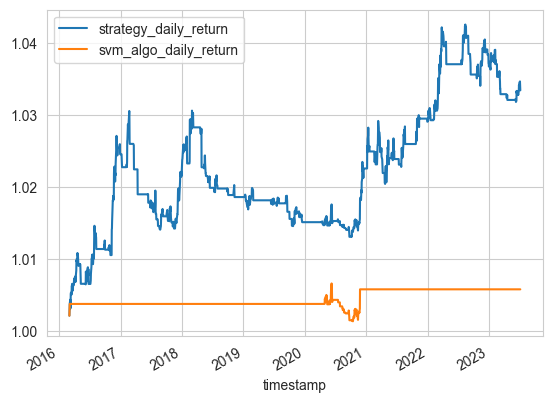

In [28]:
# compare
perf = pandas.DataFrame(index=X_test.index)
perf['prediction'] = pred
perf['strategy_daily_return'] = pos['daily_return']
perf['svm_algo_daily_return'] = pos['daily_return'] * perf['prediction']
(1 + perf[['strategy_daily_return', 'svm_algo_daily_return']]).cumprod().plot()
pass # the baton

More of what's expected. Also good to see the results from earlier (Q1 2023) are more attributable to a downturn in the stock rather than the strategy outright failing. Now let's boost it.

### AdaBoost

AdaBoost classification report
              precision    recall  f1-score   support

           0       0.70      0.06      0.11      1067
           1       0.43      0.97      0.59       781

    accuracy                           0.44      1848
   macro avg       0.56      0.51      0.35      1848
weighted avg       0.58      0.44      0.31      1848



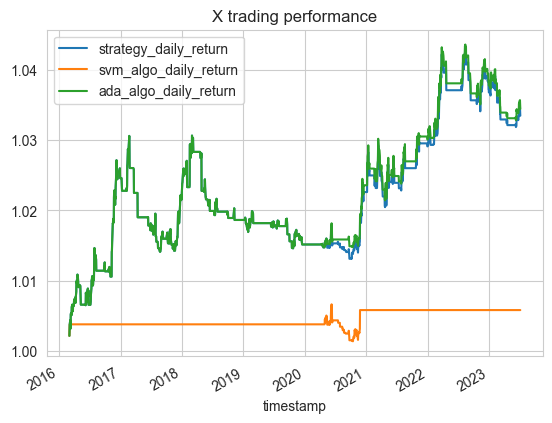

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html TL;DR - self-optimizing classifier
ada_model = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0).fit(X_train_scaled, y_train)
ada_pred = ada_model.predict(X_test_scaled)
ada_report = classification_report(y_test, ada_pred)
print('AdaBoost classification report')
print(ada_report)
ada_perf = pandas.DataFrame(index=X_test.index)
ada_perf['prediction'] = ada_pred
ada_perf['strategy_daily_return'] = pos['daily_return']
ada_perf['svm_algo_daily_return'] = pos['daily_return'] * perf['prediction']
ada_perf['ada_algo_daily_return'] = pos['daily_return'] * ada_perf['prediction']
(1 + ada_perf[['strategy_daily_return', 'svm_algo_daily_return', 'ada_algo_daily_return']]).cumprod().plot()
matplot.title('X trading performance')
pass # gas

Now *that's* a result.

This is a good stopping point for now. Now that we're caught up with the example notebook, the next step is to look for ways to improve this even further.

### Trained Model vs Strategy

After a good night's sleep this is starting to smell like overfit. To see how well it's generalized, let's test it on a few other stocks **without** retraining, and use the base strategy as a control.

In [30]:
# first, encapulate earlier processes so we can loop over them (i.e., copy/paste go brr)

def preprocess(stock:str, start:datetime=datetime(2016, 1, 1), end:datetime=datetime.today(), fast:int=4, slow:int=10) -> pandas.DataFrame:
    bars = stock_client.get_stock_bars(StockBarsRequest(symbol_or_symbols=stock, timeframe=TimeFrame.Day, start=start, end=end)).df
    data = bars.loc[:, ['close', 'vwap']]
    data['rsi'] = TA.RSI(bars)
    data['sma_fast'] = data['close'].rolling(fast).mean()
    data['sma_slow'] = data['close'].rolling(slow).mean()
    data['sma_signal'] = numpy.where(data['sma_fast'] > data['sma_slow'], 1, 0)
    data['rsi_signal'] = numpy.where(data['rsi'] > 50, 1, 0)
    data['stock_held'] = data['sma_signal'] * data['rsi_signal']
    data['trade_flag'] = data['stock_held'].diff()
    data = data.fillna(0).reset_index(level=['symbol']).drop('symbol', axis=1)
    return data

def display(data:pandas.DataFrame, stock:str, figsize:tuple[int, int]=(20, 10), height_ratios:list[int]=[2, 1], show_grid:bool=True) -> None:
    fig, axs = matplot.subplots(2, 1, figsize=figsize, height_ratios=height_ratios)
    seaborn.lineplot(data=pandas.concat([data[['close', 'vwap']], data[['sma_fast', 'sma_slow']][slow:]], axis=1), ax=axs[0])
    seaborn.scatterplot(data=data[data['trade_flag'] == -1.0], x='timestamp', y='close', color='r', ax=axs[0])
    seaborn.scatterplot(data=data[data['trade_flag'] == 1.0], x='timestamp', y='close', color='g', ax=axs[0])
    axs[0].set_title(f'{stock} Price Action')
    axs[0].set_ylabel('Price')
    axs[0].set_xlabel('Date')
    seaborn.lineplot(data=data[['rsi']], ax=axs[1])
    axs[1].set_title(f'{stock} Relative Strength Index (RSI)')
    axs[1].set_ylabel('Index')
    axs[1].set_xlabel('Date')
    if show_grid: seaborn.set_style('whitegrid')

def backtest(data:pandas.DataFrame, starting_capital:float=100000.0, shares_per_trade:int=100) -> pandas.DataFrame:
    pos = data.loc[:, ['close', 'stock_held']]
    cap = starting_capital
    amt = shares_per_trade
    pos['shares_owned'] = amt * pos['stock_held']
    pos['shares_traded'] = pos['shares_owned'].diff()
    pos['stock_value'] = pos['close'] * pos['shares_owned']
    pos['cash_value'] = cap - (pos['close'] * pos['shares_traded']).cumsum()
    pos['total_value'] = pos['cash_value'] + pos['stock_value']
    pos['daily_return'] = pos['total_value'].pct_change()
    pos['total_return'] = (1 + pos['daily_return']).cumprod() - 1
    return pos

# instead of creating and training a new model, ada_model is plugged back in
def perf_test(data:pandas.DataFrame, pos:pandas.DataFrame, stock:str, model:AdaBoostClassifier=ada_model) -> None:
    X = data.loc[:, ['rsi', 'sma_fast', 'sma_slow']].shift().dropna()
    X_scaled = StandardScaler().fit_transform(X)
    abc_pred = model.predict(X_scaled)
    abc_perf = pandas.DataFrame(index=X.index)
    abc_perf['prediction'] = abc_pred
    abc_perf['strat_daily_return'] = pos['daily_return']
    abc_perf['model_daily_return'] = pos['daily_return'] * abc_perf['prediction']
    (1 + abc_perf[['strat_daily_return', 'model_daily_return']]).cumprod().plot()
    matplot.title(f'Pretrained AdaBoost Classifier Trading Performance - {stock}, 2016 - 2023')

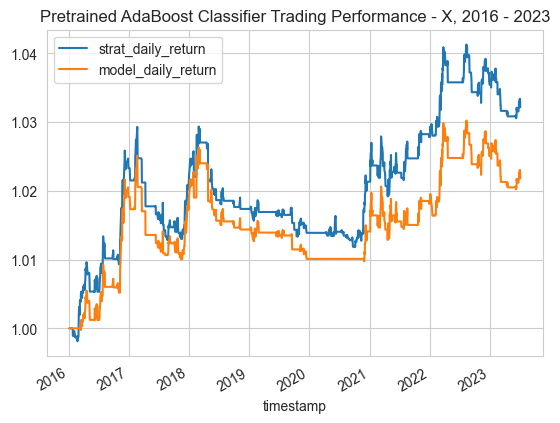

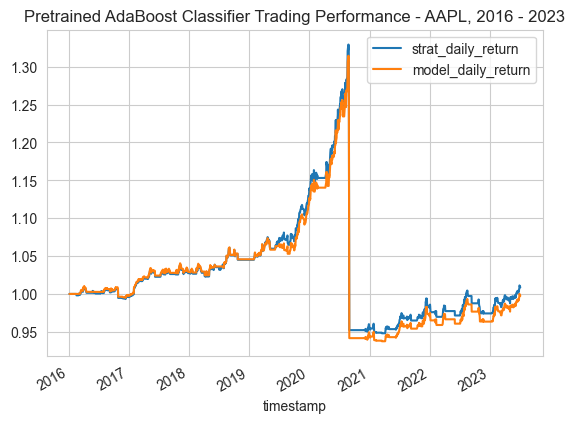

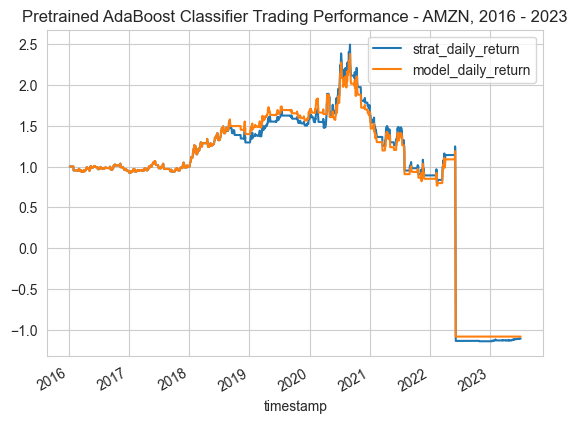

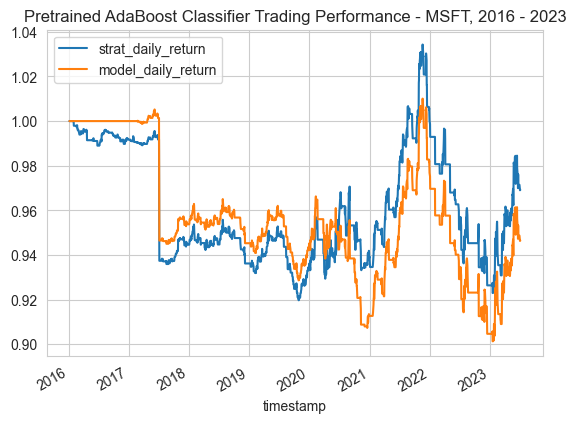

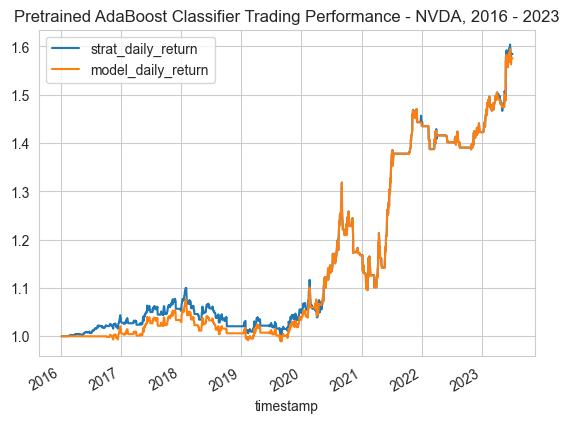

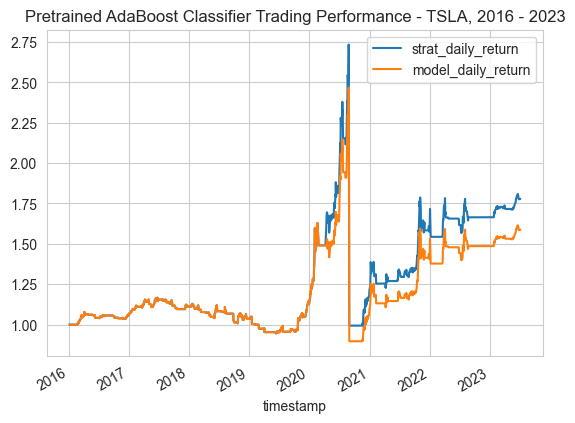

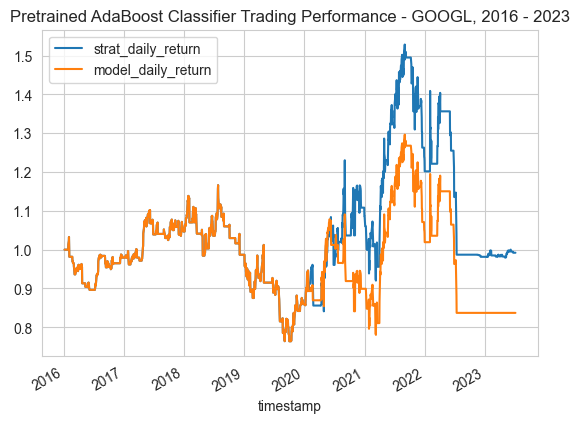

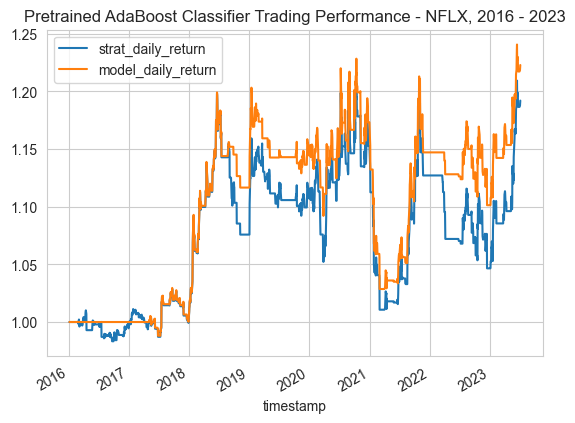

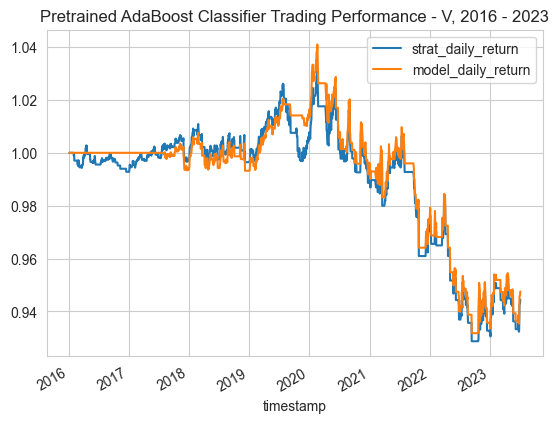

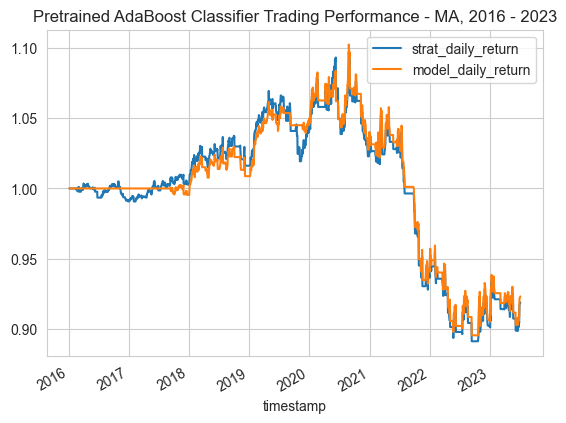

In [31]:
test_stocks = ['X', 'AAPL', 'AMZN', 'MSFT', 'NVDA', 'TSLA', 'GOOGL', 'NFLX', 'V', 'MA'] # thanks, chatGPT
for stock in test_stocks:
    data = preprocess(stock=stock)
    pos = backtest(data=data)
    # display(data=data, stock=stock) # not for loops
    perf_test(data=data, pos=pos, stock=stock)

I guess this shows an AdaBoostClassifier can learn the RSI > 50 + hot/cold SMA rule reasonably well, but it's not outperforming it. What about training it on a more complex set of indicators?

### 曇りです (It's Cloudy)

I first heard of the [Ichimoku Cloud](https://www.investopedia.com/terms/i/ichimoku-cloud.asp) over a year ago, but didn't have the chops to learn it at the time. I think this is a good opportunity to see what it can do.

,close,stock_held,shares_owned,shares_traded,stock_value,cash_value,total_value,daily_return,total_return
timestamp,,,,,,,,,
2016-01-06,7.93,0,0,0.0,0.0,100000.0,100000.0,0.0,0.00000
2016-01-07,7.30,0,0,0.0,0.0,100000.0,100000.0,0.0,0.00000
2016-01-08,7.04,0,0,0.0,0.0,100000.0,100000.0,0.0,0.00000
2016-01-11,6.82,0,0,0.0,0.0,100000.0,100000.0,0.0,0.00000
2016-01-12,6.89,0,0,0.0,0.0,100000.0,100000.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...
2023-06-28,24.45,0,0,0.0,0.0,99164.0,99164.0,0.0,-0.00836
2023-06-29,24.99,0,0,0.0,0.0,99164.0,99164.0,0.0,-0.00836
2023-06-30,25.01,0,0,0.0,0.0,99164.0,99164.0,0.0,-0.00836


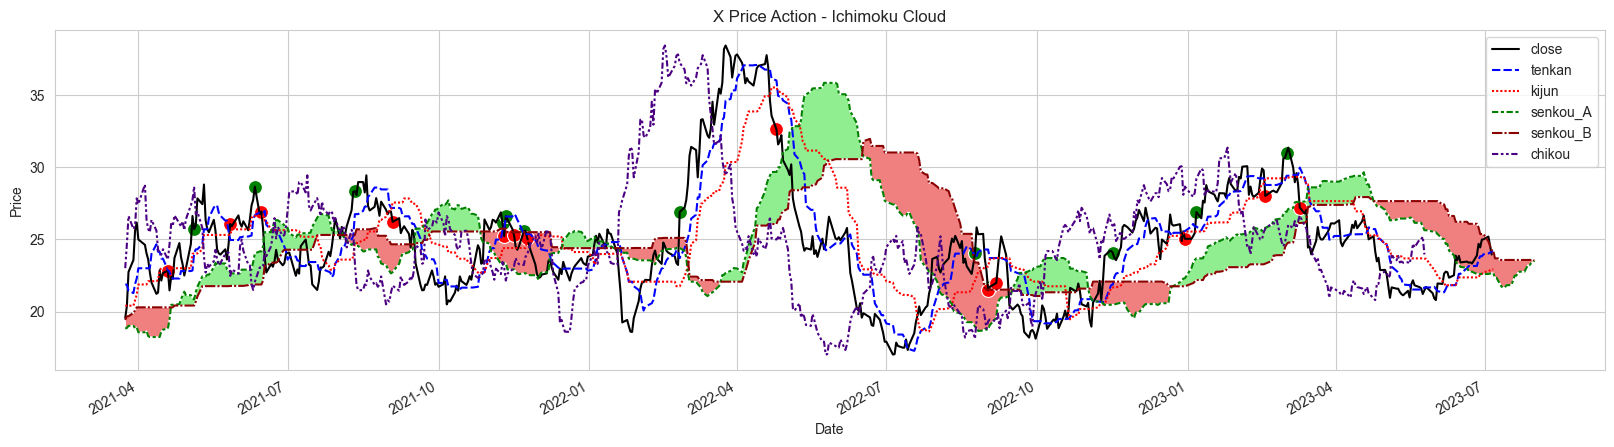

In [32]:
def ichimoku_rolling_avg(data:pandas.DataFrame, window:int, keep_cols:bool=False) -> pandas.DataFrame:
    high_colname = f'{window}_day_high'
    low_colname = f'{window}_day_low'
    # closed = 'left' exlcudes the current period from calculations, since we don't get that info until t+1
    data[high_colname] = data.loc[:, ['high']].rolling(window=window, closed='left').max()
    data[low_colname] = data.loc[:, ['low']].rolling(window=window, closed='left').min()
    line = pandas.Series(data[high_colname] + data[low_colname]).apply(lambda x : x / 2)
    if not keep_cols:
        del data[high_colname]
        del data[low_colname]
    return line

def preprocess_ichimoku(stock:str, timeframe:TimeFrame=TimeFrame.Day, start:datetime=datetime(2016, 1, 1), end:datetime=datetime.now(),
                        tenkan_lookback:int=9, kijun_lookback:int=26, senkou_lead:int=26, chikou_lag:int=26) -> pandas.DataFrame:
    data_request = StockBarsRequest(symbol_or_symbols=stock, timeframe=timeframe, start=start, end=end)
    data = stock_client.get_stock_bars(data_request).df
    data = data.loc[:, ['high', 'low', 'close']].reset_index().drop('symbol', axis=1) # drop multi-axis
    data['timestamp'] = data['timestamp'].apply(lambda x : x.date())
    # append empty rows to record leading indicators for future dates
    rows = pandas.DataFrame([[numpy.NaN] * len(data.columns)] * senkou_lead, columns=data.columns)
    rows['timestamp'] = [end.date() + timedelta(days=(x + 1)) for x in range(senkou_lead)]
    rows = rows.reset_index().drop('index', axis=1)
    data = pandas.concat([data, pandas.DataFrame(rows)], ignore_index=False)
    data = data.set_index('timestamp')
    # indicators
    data['tenkan'] = ichimoku_rolling_avg(data, tenkan_lookback)                                          # conversion line
    data['kijun'] = ichimoku_rolling_avg(data, kijun_lookback)                                            # base line
    data['senkou_A'] = pandas.Series(data.tenkan + data.kijun).apply(lambda x : x / 2).shift(senkou_lead) # leading span A
    data['senkou_B'] = ichimoku_rolling_avg(data, 2 * senkou_lead).shift(senkou_lead)                     # leading span B
    data['chikou'] = data.close.shift(-chikou_lag)                                                        # lagging span
    data['kumo_T'] = numpy.where(data.senkou_A > data.senkou_B, data.senkou_A, data.senkou_B)             # top of cloud
    data['kumo_B'] = numpy.where(data.senkou_A < data.senkou_B, data.senkou_A, data.senkou_B)             # bottom of cloud 
    #signals
    leading_data = data.shift(-senkou_lead)
    lagging_data = data.shift(chikou_lag)
    data['close_above_kumo']   = numpy.where(data.close > data.kumo_T, 1, 0)
    data['senkou_kumo_green']  = numpy.where(leading_data.senkou_A > leading_data.senkou_B, 1, 0)
    data['tenkan_above_kijun'] = numpy.where(data.tenkan > data.kijun, 1, 0) #numpy.where(numpy.logical_and(data.tenkan > data.kijun, data.shift(1).tenkan < data.shift(1).kijun), 1, 0)
    data['chikou_above_close'] = numpy.where(lagging_data.chikou > lagging_data.close, 1, 0)
    data['stock_held'] = data.close_above_kumo * data.senkou_kumo_green * data.tenkan_above_kijun * data.chikou_above_close
    data['trade_flag'] = data.stock_held.diff()
    # sell/short - blew up the account
    # data['close_below_kumo']   = numpy.where(data.close < data.kumo_B, 1, 0)
    # data['senkou_kumo_red']    = numpy.where(senkou_data.senkou_A < senkou_data.senkou_B, 1, 0)
    # data['tenkan_below_kijun'] = numpy.where(data.tenkan < data.kijun, 1, 0) #numpy.where(numpy.logical_and(data.tenkan < data.kijun, data.shift(1).tenkan > data.shift(1).kijun), 1, 0)
    # data['chikou_below_close'] = numpy.where(chikou_data.chikou < chikou_data.close, 1, 0)
    # data['short_signal'] = data.close_below_kumo * data.senkou_kumo_red * data.tenkan_below_kijun * data.chikou_below_close
    return data

def display_ichimoku(data:pandas.DataFrame, stock:str, figsize:tuple[int, int]=(13, 5), n_periods:int=300) -> None:
    matplot.figure(figsize=figsize)
    sample = data.tail(n_periods) # always look at the most recent data
    ichimoku = seaborn.lineplot(data=sample.loc[:, ['close', 'tenkan', 'kijun', 'senkou_A', 'senkou_B', 'chikou']], palette=['black', 'blue', 'red', 'green', 'darkred', 'indigo'])
    ichimoku.fill_between(sample.index, sample.senkou_A, sample.senkou_B, where=sample.senkou_A > sample.senkou_B, facecolor='lightgreen', interpolate=True)
    ichimoku.fill_between(sample.index, sample.senkou_A, sample.senkou_B, where=sample.senkou_A < sample.senkou_B, facecolor='lightcoral', interpolate=True)
    seaborn.scatterplot(data=sample[sample.trade_flag ==  1], x='timestamp', y='close', color='g', s=100)
    seaborn.scatterplot(data=sample[sample.trade_flag == -1], x='timestamp', y='close', color='r', s=100)
    matplot.title(f'{stock} Price Action - Ichimoku Cloud')
    matplot.ylabel('Price')
    matplot.xlabel('Date')
    matplot.gcf().autofmt_xdate()
    seaborn.set_style('whitegrid')

# https://medium.com/swlh/ichimoku-kinko-hyo-the-full-guide-in-python-e7b05f076307
def backtest_ichimoku(data:pandas.DataFrame, starting_capital:float=100000.0, shares_per_trade:int=100) -> pandas.DataFrame:
    pos = data.loc[:, ['close', 'stock_held']]
    cap = starting_capital
    amt = shares_per_trade
    pos['shares_owned'] = amt * pos.stock_held
    pos['shares_traded'] = pos.shares_owned.diff()
    pos['stock_value'] = pos.close * pos.shares_owned
    pos['cash_value'] = cap - (pos.close * pos.shares_traded).cumsum()
    pos['total_value'] = pos.cash_value + pos.stock_value
    pos['daily_return'] = pos.total_value.pct_change()
    pos['total_return'] = (1 + pos.daily_return).cumprod() - 1
    pos = pos.dropna() # remove future rows
    return pos

cloud = preprocess_ichimoku('X') #, timeframe=TimeFrame(4, TimeFrameUnit.Hour), start=datetime(2022, 6, 1))
display_ichimoku(cloud, 'X', n_periods=600, figsize=(20, 5))
# cloud.tail(600)
backtest_ichimoku(cloud)

Not the worst. Let's compare X's performance to our `test_stocks`.

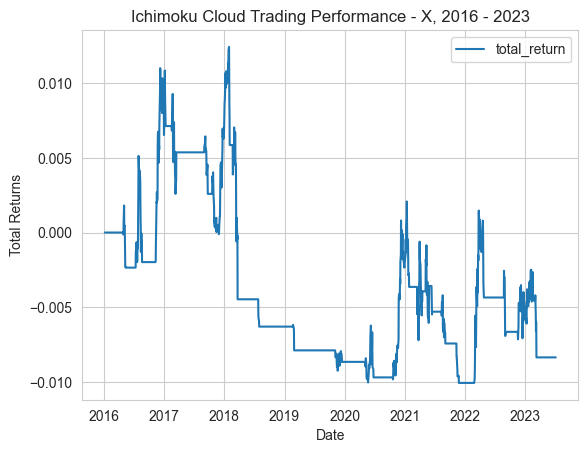

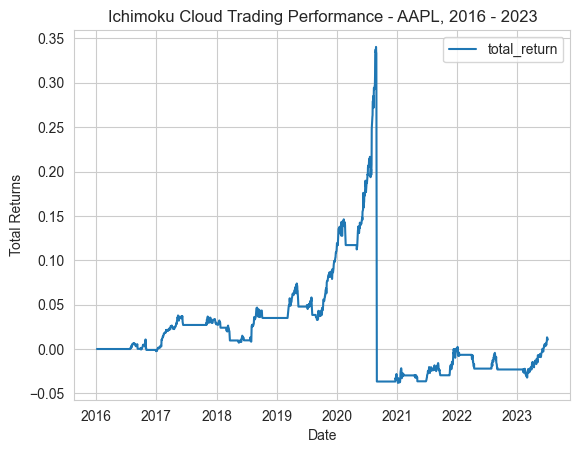

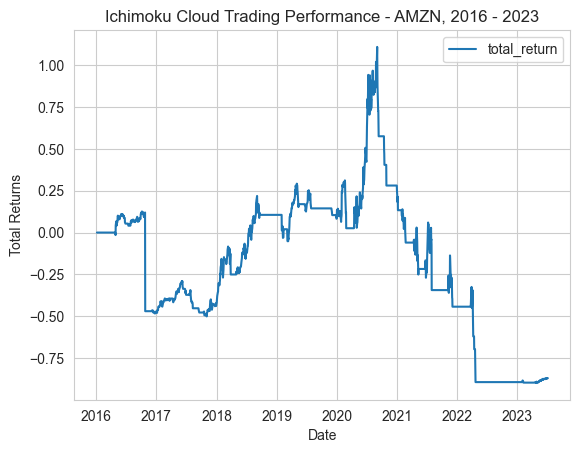

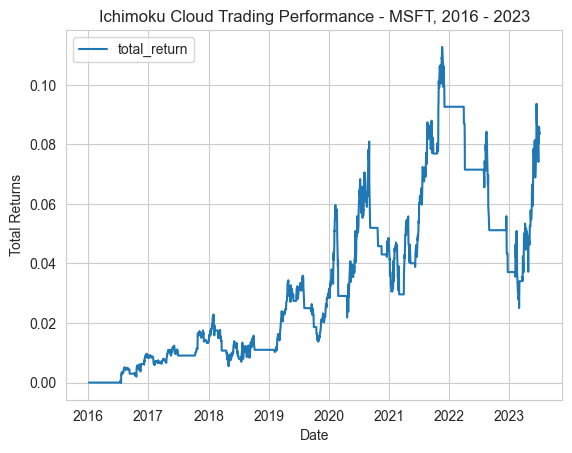

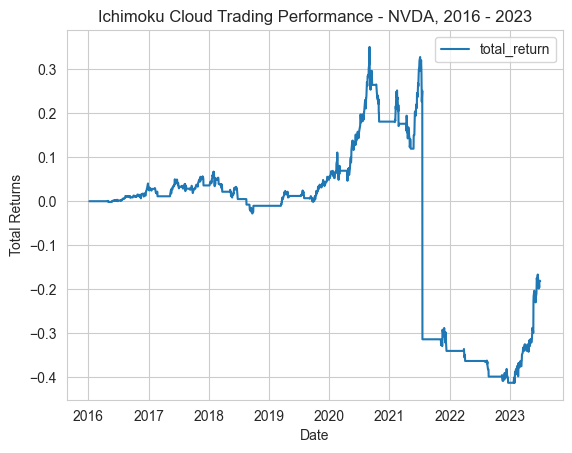

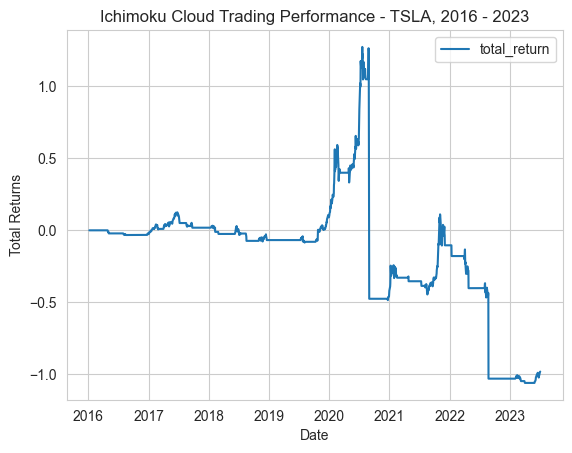

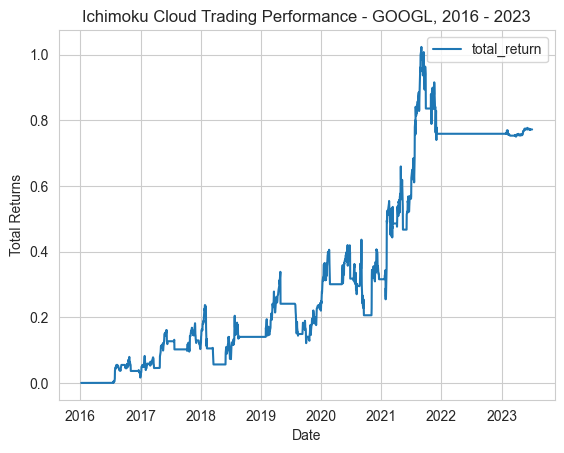

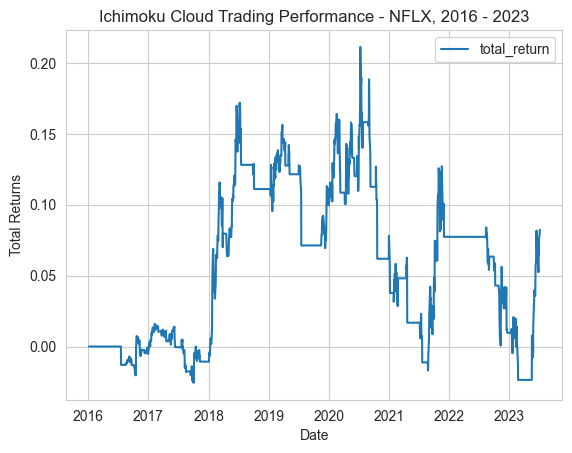

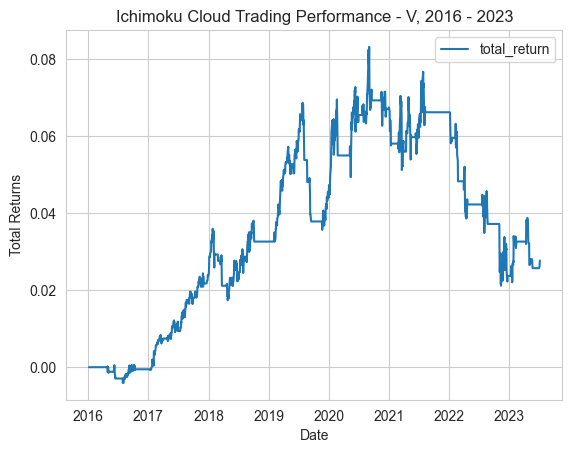

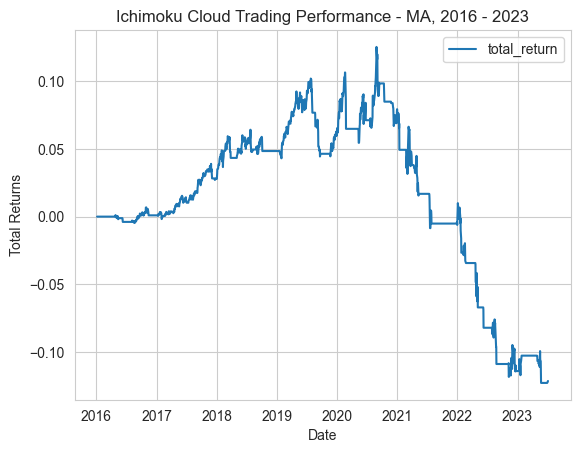

In [33]:
for stock in test_stocks:
    cloud = preprocess_ichimoku(stock)
    backtest_ichimoku(cloud).loc[:, ['total_return']].plot()
    matplot.title(f'Ichimoku Cloud Trading Performance - {stock}, 2016 - 2023')
    matplot.xlabel('Date')
    matplot.ylabel('Total Returns')

Here's how each strategy did:
* **SMA Signals** - This performed best for every company besides NFLX and V.
* **AdaBoosted SMA** - This claimed NFLX and V, just barely edging out the SMA strategy.
* **Ichimoku** - Underperformed on every stock and lost money on most.

The SMA strategy was far and away the best - the author(s) the [original notebook](https://nbviewer.org/github/ORE93/Automated-Algorithmic-Trading-Bot/blob/main/Algo_trade.ipynb) knew what they were doing. Compared the the AdaBoost model they're almost indistinguishable, and while that speaks to the performance of the model, it doesn't provide a significant advantage that would justify using it over the hard-coded SMA rule.

Meanwhile, the Ichimoku got *completely* blown out of the water, likely due to how I setup the trading rules. Everyone seems to have their own version of these, which I presume must be developed over time. Definitely something I want to revisit but for now let's wrap up by using these signals [to send buy/sell orders to the Alpaca API](https://alpaca.markets/docs/python-sdk/trading.html).

### Understanding the Assignment

In [34]:
trade_client = TradingClient(api['KEY'], api['SECRET'], paper=True)
trade_signal = 1 # preprocess(stock=stock, start=datetime(2023, 1, 1)).tail(1)['trade_flag'].values[0]
if trade_signal > 0:
    print('Ordering 100 shares...')
    market_order = MarketOrderRequest(symbol='X', qty=100, side=OrderSide.BUY, time_in_force=TimeInForce.DAY)
    trade_client.submit_order(order_data=market_order)
elif trade_signal < 0:
    print('Closing all orders and positions...')
    trade_client.close_all_positions(cancel_orders=True)
else:
    print('No action taken.')
time.sleep(5) # API needs a few seconds to update
print('Open Orders: ', trade_client.get_orders())
print('Open Positions: ', trade_client.get_all_positions())

Ordering 100 shares...
Open Orders:  [{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
    'asset_id': UUID('4ea43090-b5be-42bd-a4a8-f4607616fe0e'),
    'canceled_at': None,
    'client_order_id': '360bd5e1-30e8-44a9-a8ff-21586d83b748',
    'created_at': datetime.datetime(2023, 7, 6, 1, 20, 54, 972994, tzinfo=datetime.timezone.utc),
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': UUID('8828e7ae-3626-48c7-a808-21b2b17457d6'),
    'legs': None,
    'limit_price': None,
    'notional': None,
    'order_class': <OrderClass.SIMPLE: 'simple'>,
    'order_type': <OrderType.MARKET: 'market'>,
    'qty': '100',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': <OrderSide.BUY: 'buy'>,
    'status': <OrderStatus.ACCEPTED: 'accepted'>,
    'stop_price': None,
    'submitted_at': datetime.datetime(2023, 7, 6, 1, 20, 54, 972151, t

### Conclusions

While I came into this more excited about he ML side of things, what I really took away was how well the SMA + RSI strategy performed and how little the classifier changed that performance. Maybe it'll be a different story once deep learning gets involved, but for now most of the credit goes to the power of technical analysis, and the teams that built such easy-to-use APIs.